In [1]:
import re
import pandas as pd
from time import time
from collections import defaultdict
import spacy
from spacy import displacy

In [2]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [32]:
df = pd.read_csv('lear.txt', sep="\n", header=None)
df.shape

(112, 1)

In [33]:
nlp = spacy.load('en')

In [34]:
def cleaning(doc):
    #removing stop-words and lemmatizing
    txt = [token.lemma_ for token in doc if not token.is_stop]
    #getting rid of small sentences
    if len(txt) > 2:
        return ' '.join(txt)

In [35]:
#generator for lower-case formatting
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower()
                 for row in df[0])

In [36]:
#cleaning&tokenizing
txt = [cleaning(doc) for doc in 
       nlp.pipe(brief_cleaning, batch_size=200, n_threads=-1)]

In [37]:
#the new clean dataframe
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(112, 1)

In [38]:
from gensim.models.phrases import Phrases, Phraser

In [39]:
sent = [row.split() for row in df_clean['clean']]
phrases = Phrases(sent, min_count = 10)

2019-12-31 12:33:03,027 : INFO : collecting all words and their counts
2019-12-31 12:33:03,029 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2019-12-31 12:33:03,050 : INFO : collected 1889 word types from a corpus of 1538 words (unigram + bigrams) and 112 sentences
2019-12-31 12:33:03,052 : INFO : using 1889 counts as vocab in Phrases<0 vocab, min_count=10, threshold=10.0, max_vocab_size=40000000>


In [40]:
bigrams = Phraser(phrases)
bigrams

2019-12-31 12:33:03,148 : INFO : source_vocab length 1889
2019-12-31 12:33:03,205 : INFO : Phraser built with 2 phrasegrams


In [41]:
sentences = bigrams[sent]

In [42]:
#frequently found 2-word phrases
dubl = []
for sent in sentences:
    for word in sent:
        if '_' in word:
            dubl.append(word)
dubl = list(dict.fromkeys(dubl))
print(dubl)

['old_man', 'young_lady']


In [43]:
#creating a frequency dictionary
word_freq = defaultdict(int)
for sent in sentences:
    for word in sent:
        word_freq[word] += 1
len(word_freq)

729

In [44]:
#top-15 most frequently used words and their frequencies
top = sorted(word_freq, key=word_freq.get, reverse=True)[:15]
for word in top:
    print('{:10} {:10}'.format(word, word_freq[word]))

old_man            90
person             53
old                49
say                32
young_lady         28
till               11
sit                10
nose               10
conduct             9
man                 8
lady                8
reply               8
large               8
rush                7
play                6


In [45]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

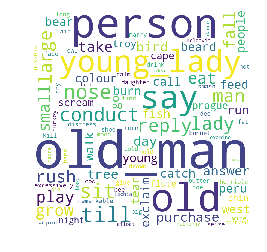

In [46]:
text = ''
for sent in sentences:
    for word in sent:
        text = text + str(word) + ' '
wc = WordCloud(background_color="white", max_words=100, max_font_size=200, width=800, height=800, collocations=False).generate(text)
plt.imshow(wc)
plt.axis('off')
plt.show()

In [47]:
import multiprocessing
from gensim.models import Word2Vec

In [48]:
#counting number of vectors
cores = multiprocessing.cpu_count()

In [49]:
w2v_model = Word2Vec(min_count=3, window=2, size=60, sample=6e-5,
                    alpha=0.03, min_alpha=0.0007, negative=5,
                    workers=cores-1, batch_words=100)

In [50]:
t = time()
w2v_model.build_vocab(sentences, progress_per=50)
print('time to build vocab: {}'.format(round(time()-t, 2)))

2019-12-31 12:34:05,658 : INFO : collecting all words and their counts
2019-12-31 12:34:05,662 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-12-31 12:34:05,682 : INFO : PROGRESS: at sentence #50, processed 638 words, keeping 393 word types
2019-12-31 12:34:05,703 : INFO : PROGRESS: at sentence #100, processed 1266 words, keeping 677 word types
2019-12-31 12:34:05,707 : INFO : collected 729 word types from a corpus of 1420 raw words and 112 sentences
2019-12-31 12:34:05,710 : INFO : Loading a fresh vocabulary
2019-12-31 12:34:05,716 : INFO : effective_min_count=3 retains 86 unique words (11% of original 729, drops 643)
2019-12-31 12:34:05,718 : INFO : effective_min_count=3 leaves 595 word corpus (41% of original 1420, drops 825)
2019-12-31 12:34:05,724 : INFO : deleting the raw counts dictionary of 729 items
2019-12-31 12:34:05,726 : INFO : sample=6e-05 downsamples 86 most-common words
2019-12-31 12:34:05,729 : INFO : downsampling leaves estimated 40 wo

time to build vocab: 0.09


In [51]:
t = time()
w2v_model.train(sentences, total_examples=w2v_model.corpus_count,
               epochs=20, report_delay=1)
print('time to train the model: {}'.format(round(time()-t, 2)))

2019-12-31 12:34:32,273 : INFO : training model with 3 workers on 86 vocabulary and 60 features, using sg=0 hs=0 sample=6e-05 negative=5 window=2
2019-12-31 12:34:32,543 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-12-31 12:34:32,546 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-12-31 12:34:32,549 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-12-31 12:34:32,551 : INFO : EPOCH - 1 : training on 1420 raw words (45 effective words) took 0.2s, 185 effective words/s
2019-12-31 12:34:32,612 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-12-31 12:34:32,615 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-12-31 12:34:32,622 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-12-31 12:34:32,626 : INFO : EPOCH - 2 : training on 1420 raw words (29 effective words) took 0.1s, 499 effective words/s
2019-12-31 12:34:32,681 : INFO : worker thread finished;

time to train the model: 1.87


In [52]:
#normalizing L2-vectors !!after it training is impossible!!
w2v_model.init_sims(replace=True)

2019-12-31 12:34:48,740 : INFO : precomputing L2-norms of word weight vectors


In [53]:
w2v_model.wv.most_similar(positive=['person'])

[('feed', 0.2685703635215759),
 ('bonnet', 0.25295472145080566),
 ('dee', 0.2517716884613037),
 ('tear', 0.24499636888504028),
 ('lady', 0.23650142550468445),
 ('bee', 0.2315416783094406),
 ('cold', 0.22595718502998352),
 ('excessively', 0.20867744088172913),
 ('face', 0.18656057119369507),
 ('moon', 0.1861191689968109)]

In [56]:
w2v_model.wv.similarity('face', 'nose')

-0.20799275

In [57]:
w2v_model.wv.syn0.shape

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  """Entry point for launching an IPython kernel.


(86, 60)